начало


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
train = pd.read_excel('train.xlsx')
test = pd.read_excel('test.xlsx')
train.head()# загружаем данные и смотрим  первые  пять записей  и  делаем  первые  выводы о данных


,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300


In [ ]:
import yfinance as yf
import pandas as pd

# Задаем временной диапазон
start_date = "2015-01-05"
end_date = "2022-08-29"

# Загружаем данные по курсу доллара к рублю (USD/RUB)
# Используем тикер "USDRUB=X" для получения курса доллара к рублю
data = yf.download("USDRUB=X", start=start_date, end=end_date, interval="1wk")

# Оставляем только колонку с ценами закрытия (Close)
data = data[['Close']]

# Переименовываем колонку для удобства
data.rename(columns={'Close': 'USD_RUB'}, inplace=True)

# Сбрасываем индекс, чтобы дата стала колонкой
data.reset_index(inplace=True)

# Сохраняем датасет в CSV (опционально)
data.to_csv("usd_rub_weekly_2015_2022.csv", index=False)

# Выводим первые 5 строк датасета
data.tail()

[*********************100%***********************]  1 of 1 completed


Price,Date,USD_RUB
Ticker,,USDRUB=X
394,2022-07-25,62.465
395,2022-08-01,61.465
396,2022-08-08,60.590
397,2022-08-15,59.965
398,2022-08-22,60.340


In [ ]:
# переименовываем столбцы
data = data.rename(columns={'Date': 'dt'})

In [ ]:
import numpy as np
test.shape

(28, 2)

In [ ]:
# !pip install catboost
import catboost
from catboost import CatBoostRegressor

In [ ]:
train.shape #сразу смотрим сколько строк и клонок

(400, 2)

In [ ]:
train.describe() #стата по колонкам

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


<Axes: >

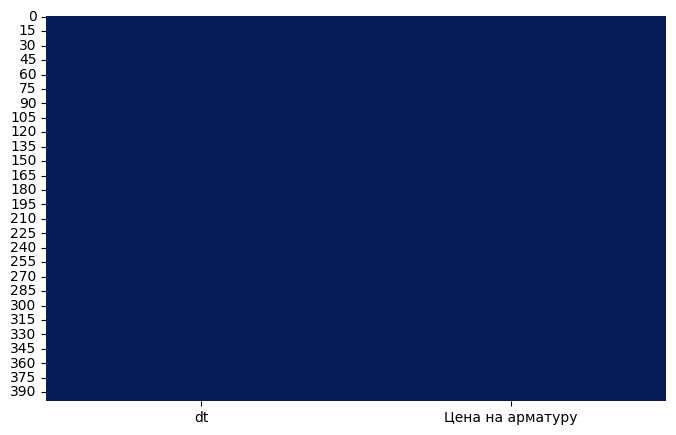

In [ ]:
plt.figure(figsize = (8,5)) #пропуски
sns.heatmap(train.isnull(),cmap="YlGnBu_r",cbar=False)

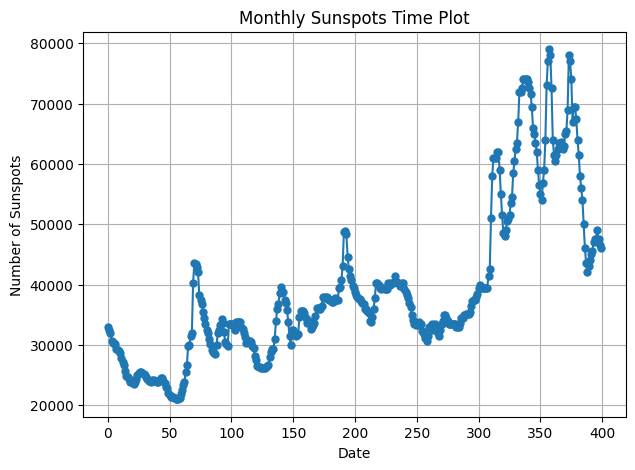

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(train.index, train['Цена на арматуру'], marker='o', linestyle='-', markersize=5)
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.title('Monthly Sunspots Time Plot')
plt.grid(True)
plt.show()

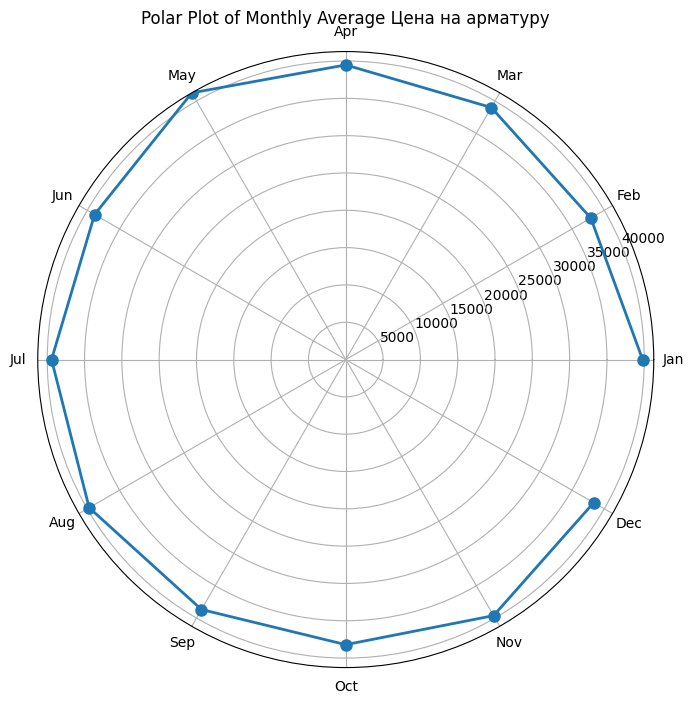

In [ ]:

# Создаем копию данных
train1 = train.copy()

# Извлекаем год и месяц из даты
train1['year'] = pd.DatetimeIndex(train1['dt']).year
train1['month'] = pd.DatetimeIndex(train1['dt']).month

# Группируем по месяцу и вычисляем среднее значение
monthly_average = train1.groupby('month')['Цена на арматуру'].mean()

# Углы для каждого месяца (12 месяцев)
theta = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 точек, чтобы избежать наложения
radii = monthly_average.values

# Названия месяцев
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Полярный график
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='polar')

# Рисуем график
ax.plot(theta, radii, marker='o', linestyle='-', linewidth=2, markersize=8)

# Добавляем названия месяцев
ax.set_xticks(theta)
ax.set_xticklabels(months)

# Устанавливаем пределы для оси y
ax.set_ylim(0, radii.max() + 10)

# Заголовок
plt.title('Polar Plot of Monthly Average Цена на арматуру', pad=20)

# Показать график
plt.show()

In [ ]:
test.head()

,dt,Цена на арматуру
0,2022-09-05,46000
1,2022-09-12,46000
2,2022-09-19,46000
3,2022-09-26,45500
4,2022-10-03,45500


In [ ]:
# Подготовка тренировочной выборки
df_train = pd.DataFrame()
df_train['dt'] = pd.to_datetime(train['dt'])
df_train['Price'] = train['Цена на арматуру']
df_train['istest'] = 0

# Подготовка тестовой выборки
df_test = pd.DataFrame()
df_test['dt'] = pd.to_datetime(test['dt'])
df_test['Price'] = test['Цена на арматуру']
df_test['istest'] = 1

# Конкатинируем в один датасет с метрой `istest`
raw = pd.concat((df_train, df_test)).reset_index(drop=True)


# Посмотрим на тип переменных
raw.dtypes

,0
dt,datetime64[ns]
Price,int64
istest,int64


In [ ]:
# Создадим матрицы со сдвигом, то есть сделаем так чтобы значение
# цены на следующую неделю являлось "неизвестным для модели"
X = raw.drop(columns=['Price']).iloc[:-1, :]
y = raw['Price'].values[1:]


In [ ]:
X['Price_target'] = y
X['Price_source'] = raw['Price'].values[:-1]

# Подсчитаем разницу между текущим и прошлым значением цены на покупку арматуры
price_diff = X['Price_source'] - X['Price_target']


In [ ]:
y = X['Price_target']
X = X.drop(columns=['Price_target', 'dt'])

# Удаляем первую строку
X = X.drop([0])

# Добавляем разницу в цене
X['Price_Diff'] = price_diff.values[:-1]
X

,istest,Price_source,Price_Diff
1,0,32500,400
2,0,32000,500
3,0,30700,1300
4,0,30300,400
5,0,30300,0
...,...,...,...
422,1,44500,-1700
423,1,44500,0
424,1,46000,-1500
425,1,49200,-3200


In [ ]:
y


,Price_target
0,32500
1,32000
2,30700
3,30300
4,30300
...,...
422,44500
423,46000
424,49200
425,53700


In [ ]:
print(f"X shape: {X.shape}")  # Количество строк и столбцов в X
print(f"y shape: {y.shape}")  # Количество элементов в y

X shape: (426, 3)
y shape: (427,)


<Axes: >

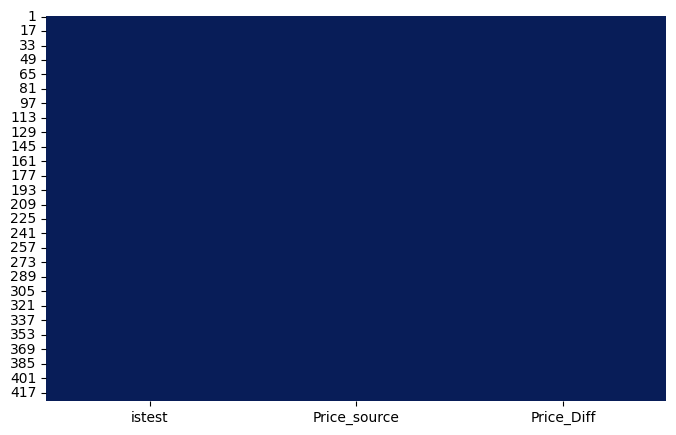

In [ ]:
plt.figure(figsize = (8,5)) #пропуски
sns.heatmap(X.isnull(),cmap="YlGnBu_r",cbar=False)

In [ ]:
# y = y[:X.shape[0]]
# y = y[:-1]

In [ ]:
print(f"X shape: {X.shape}")  # Количество строк и столбцов в X
print(f"y shape: {y.shape}")  # Количество элементов в y

X shape: (426, 3)
y shape: (427,)


In [ ]:
y = y[X.index]  # Пересинхронизируем индексы
X_for_train = (X['istest'] == 0)

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X[X_for_train].drop(columns=['istest']),
    y[X_for_train],
    test_size=0.2,
    shuffle=False
)



In [ ]:
from sklearn.model_selection import train_test_split

# Разделяем данные: 80% - для обучения, 20% - для валидации
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# Проверим размеры выборок
print(f"X_train: {X_train.shape}, X_holdout: {X_holdout.shape}")
print(f"y_train: {y_train.shape}, y_holdout: {y_holdout.shape}")


X_train: (340, 3), X_holdout: (86, 3)
y_train: (340,), y_holdout: (86,)


In [ ]:
# y_holdout = y_holdout.sort_index()
# y_pred = y_pred.sort_index()

In [ ]:
model0 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.03,  eval_metric="MAE",
                           early_stopping_rounds = 50 , random_state=42

                        )
model1 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.03,  eval_metric="MAE",
                           early_stopping_rounds = 100 , random_state=52

                        )
model2 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.05,  eval_metric="MAE",
                           early_stopping_rounds = 100 , random_state=117

                        )

In [ ]:
model0.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)


0:	learn: 6582.4852968	test: 20812.4186128	best: 20812.4186128 (0)	total: 7.65ms	remaining: 7.65s
1:	learn: 6416.5935357	test: 20284.7242060	best: 20284.7242060 (1)	total: 8.5ms	remaining: 4.24s
2:	learn: 6254.2779248	test: 19930.2041768	best: 19930.2041768 (2)	total: 11.9ms	remaining: 3.94s
3:	learn: 6071.0506366	test: 19442.4493390	best: 19442.4493390 (3)	total: 15.4ms	remaining: 3.83s
4:	learn: 5927.4968120	test: 19164.4178972	best: 19164.4178972 (4)	total: 22.1ms	remaining: 4.4s
5:	learn: 5807.4137912	test: 18980.3354901	best: 18980.3354901 (5)	total: 22.7ms	remaining: 3.76s
6:	learn: 5662.0228044	test: 18675.2417273	best: 18675.2417273 (6)	total: 25.7ms	remaining: 3.64s
7:	learn: 5512.6798807	test: 18235.9797880	best: 18235.9797880 (7)	total: 28.7ms	remaining: 3.55s
8:	learn: 5380.9908855	test: 18000.0859380	best: 18000.0859380 (8)	total: 31.5ms	remaining: 3.47s
9:	learn: 5267.3640676	test: 17867.4464779	best: 17867.4464779 (9)	total: 34.5ms	remaining: 3.42s
10:	learn: 5125.499758

In [ ]:
model1.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)


0:	learn: 6588.3897084	test: 20975.7441906	best: 20975.7441906 (0)	total: 3.27ms	remaining: 3.27s
1:	learn: 6407.0785360	test: 20435.6625747	best: 20435.6625747 (1)	total: 6.8ms	remaining: 3.39s
2:	learn: 6254.6353904	test: 20231.1409999	best: 20231.1409999 (2)	total: 10.1ms	remaining: 3.37s
3:	learn: 6111.9957648	test: 19991.0993216	best: 19991.0993216 (3)	total: 12.9ms	remaining: 3.21s
4:	learn: 5993.5297623	test: 19755.3032920	best: 19755.3032920 (4)	total: 16ms	remaining: 3.19s
5:	learn: 5855.7872483	test: 19470.8236389	best: 19470.8236389 (5)	total: 19.2ms	remaining: 3.19s
6:	learn: 5716.2131202	test: 19225.8191023	best: 19225.8191023 (6)	total: 22ms	remaining: 3.12s
7:	learn: 5574.5690068	test: 18933.7567204	best: 18933.7567204 (7)	total: 24.5ms	remaining: 3.03s
8:	learn: 5440.8498185	test: 18705.7000956	best: 18705.7000956 (8)	total: 27.4ms	remaining: 3.02s
9:	learn: 5322.2254931	test: 18509.6820031	best: 18509.6820031 (9)	total: 30.1ms	remaining: 2.98s
10:	learn: 5212.2212562	t

In [ ]:
model2.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)

0:	learn: 6429.1544060	test: 20412.0930102	best: 20412.0930102 (0)	total: 3.15ms	remaining: 3.15s
1:	learn: 6194.7933732	test: 20004.8778878	best: 20004.8778878 (1)	total: 6.19ms	remaining: 3.09s
2:	learn: 5936.2406120	test: 19231.1903763	best: 19231.1903763 (2)	total: 9.04ms	remaining: 3s
3:	learn: 5716.3163072	test: 18917.9714928	best: 18917.9714928 (3)	total: 13.7ms	remaining: 3.41s
4:	learn: 5518.9545684	test: 18590.8404349	best: 18590.8404349 (4)	total: 16.6ms	remaining: 3.3s
5:	learn: 5319.1143462	test: 18289.8315860	best: 18289.8315860 (5)	total: 17.2ms	remaining: 2.85s
6:	learn: 5074.9509619	test: 17471.7247558	best: 17471.7247558 (6)	total: 19.9ms	remaining: 2.82s
7:	learn: 4838.4244392	test: 16829.9047988	best: 16829.9047988 (7)	total: 22.6ms	remaining: 2.81s
8:	learn: 4676.5002839	test: 16570.5825555	best: 16570.5825555 (8)	total: 25.4ms	remaining: 2.8s
9:	learn: 4479.2508968	test: 16191.4217486	best: 16191.4217486 (9)	total: 29.1ms	remaining: 2.88s
10:	learn: 4277.3784520	t

In [ ]:
ypred = (model0.predict(X_holdout) +
         model1.predict(X_holdout) +
         model2.predict(X_holdout)) / 3

result = pd.DataFrame({'real': y_holdout, 'pred': ypred})
result['error'] = result['real'] - result['pred']
result = result.sort_index()
result.tail(12)

,real,pred,error
415,42500,41264.728540,1235.271460
416,42700,44675.769877,-1975.769877
417,42700,43371.078419,-671.078419
418,42700,42730.610568,-30.610568
419,42800,42730.610568,69.389432
420,42800,43401.381128,-601.381128
421,44500,43078.918861,1421.081139
422,44500,46608.987960,-2108.987960
423,46000,45583.502423,416.497577
424,49200,46268.453530,2931.546470


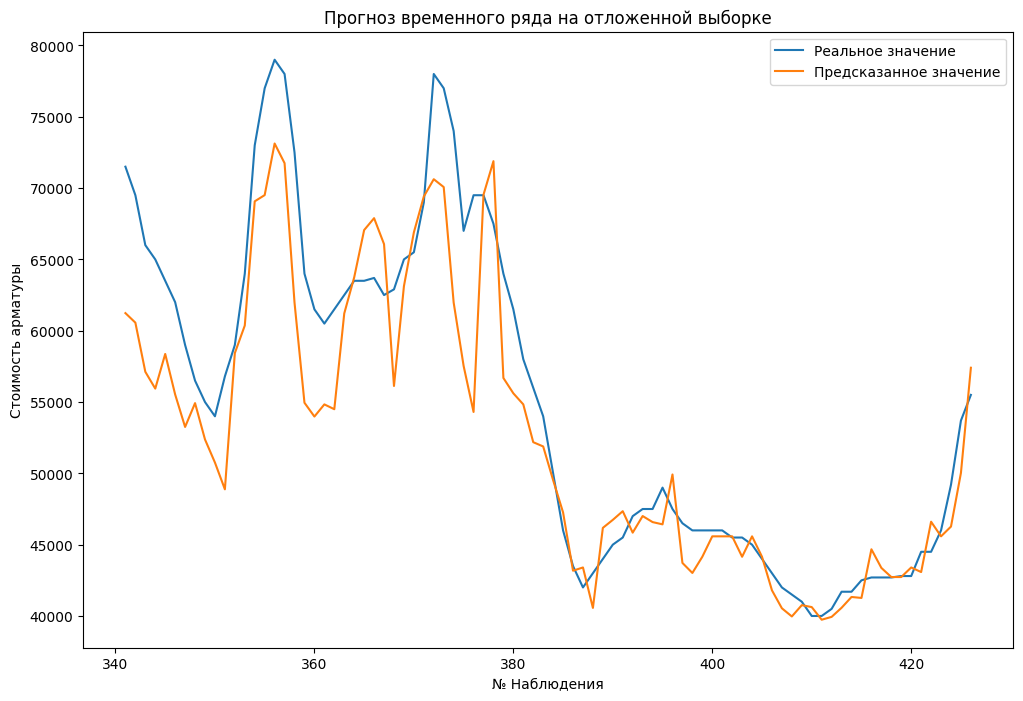

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=100)


plt.plot(result['real'], label='Реальное значение');
plt.plot(result['pred'], label='Предсказанное значение');
plt.title('Прогноз временного ряда на отложенной выборке')
plt.xlabel('№ Наблюдения')
plt.ylabel('Стоимость арматуры')
plt.legend();


In [ ]:

data_for_test = X[X['istest'] == 1]
ypred = (model0.predict(data_for_test) +
         model1.predict(data_for_test) +
         model2.predict(data_for_test)) / 3



result = pd.DataFrame({'real': y[X['istest'] == 1][1:],
              'pred': ypred[:-1]})
result['error'] = result['real'] - result['pred']
result.tail(12)


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Предположим, что result['real'] и result['pred'] содержат реальные и предсказанные значения
mae = mean_absolute_error(result['real'], result['pred'])
mse = mean_squared_error(result['real'], result['pred'])
rmse = mse ** 0.5
r2 = r2_score(result['real'], result['pred'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")



MAE: 1401.151734288064
MSE: 4704031.206943605
RMSE: 2168.877868148321
R2: 0.6528526689605993


In [ ]:
# Модель 0
model0 = CatBoostRegressor(
    iterations=2000,
    depth=8,
    loss_function='MAE',
    learning_rate=0.01,
    eval_metric="MAE",
    early_stopping_rounds=200,
    l2_leaf_reg=3,
    bagging_temperature=0.5,
    random_strength=1,
    random_state=42,
    verbose=100
)

# Модель 1
model1 = CatBoostRegressor(
    iterations=2000,
    depth=8,
    loss_function='MAE',
    learning_rate=0.02,
    eval_metric="MAE",
    early_stopping_rounds=200,
    l2_leaf_reg=5,
    bagging_temperature=1,
    random_strength=1,
    random_state=52,
    verbose=100
)

# Модель 2
model2 = CatBoostRegressor(
    iterations=3000,
    depth=6,
    loss_function='MAE',
    learning_rate=0.01,
    eval_metric="MAE",
    early_stopping_rounds=200,
    l2_leaf_reg=3,
    bagging_temperature=0.5,
    random_strength=1,
    random_state=117,
    verbose=100
)

model0.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)
model1.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)
model2.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)

0:	learn: 6691.8500002	test: 21085.5348858	best: 21085.5348858 (0)	total: 1.23ms	remaining: 2.46s
100:	learn: 3143.6628281	test: 13390.6904397	best: 13390.6904397 (100)	total: 168ms	remaining: 3.17s
200:	learn: 1726.2065229	test: 8598.3419630	best: 8598.3419630 (200)	total: 364ms	remaining: 3.25s
300:	learn: 1061.7744588	test: 6058.6961446	best: 6058.6961446 (300)	total: 556ms	remaining: 3.14s
400:	learn: 772.9803226	test: 4664.9772681	best: 4664.9772681 (400)	total: 772ms	remaining: 3.08s
500:	learn: 643.7348549	test: 4061.5062245	best: 4061.5062245 (500)	total: 982ms	remaining: 2.94s
600:	learn: 565.5166589	test: 3761.9659562	best: 3761.9659562 (600)	total: 1.13s	remaining: 2.63s
700:	learn: 525.7764002	test: 3634.4967381	best: 3634.4967381 (700)	total: 1.34s	remaining: 2.48s
800:	learn: 499.8368049	test: 3568.5826606	best: 3567.4118252 (798)	total: 1.56s	remaining: 2.34s
900:	learn: 475.9769990	test: 3535.2642781	best: 3535.2642781 (900)	total: 1.67s	remaining: 2.04s
1000:	learn: 45

In [ ]:
ypred = (model0.predict(X_holdout) +
         model1.predict(X_holdout) +
         model2.predict(X_holdout)) / 3

result = pd.DataFrame({'real': y_holdout, 'pred': ypred})
result['error'] = result['real'] - result['pred']
result = result.sort_index()
result.tail(12)

,real,pred,error
415,42500,41747.478597,752.521403
416,42700,43751.014872,-1051.014872
417,42700,43227.899681,-527.899681
418,42700,43061.946883,-361.946883
419,42800,43061.946883,-261.946883
420,42800,43381.981464,-581.981464
421,44500,43533.058261,966.941739
422,44500,46154.575776,-1654.575776
423,46000,45343.952778,656.047222
424,49200,45991.098621,3208.901379


In [ ]:

data_for_test = X[X['istest'] == 1]
ypred = (model0.predict(data_for_test) +
         model1.predict(data_for_test) +
         model2.predict(data_for_test)) / 3



result = pd.DataFrame({'real': y[X['istest'] == 1][1:],
              'pred': ypred[:-1]})
result['error'] = result['real'] - result['pred']
result.tail(12)


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Предположим, что result['real'] и result['pred'] содержат реальные и предсказанные значения
mae = mean_absolute_error(result['real'], result['pred'])
mse = mean_squared_error(result['real'], result['pred'])
rmse = mse ** 0.5
r2 = r2_score(result['real'], result['pred'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")


MAE: 1264.9303845623056
MSE: 4678341.019087963
RMSE: 2162.947299193386
R2: 0.6547485492716871


In [ ]:
mak = pd.read_excel('Макропоказатели.xlsx')
price = pd.read_excel('Цены на сырье.xlsx')
mak

,dt,Базовый индекс потребительских цен на товары и услуги,Ключевая ставка,Курс доллара
0,2016-01-31,NaN,NaN,NaN
1,2016-02-29,NaN,NaN,NaN
2,2016-03-31,NaN,NaN,NaN
3,2016-04-30,NaN,NaN,NaN
4,2016-05-31,NaN,NaN,NaN
...,...,...,...,...
1667,2023-06-10,NaN,NaN,82.6417
1668,2023-06-13,NaN,7.5,NaN
1669,2023-06-14,NaN,7.5,83.6405
1670,2023-06-15,NaN,7.5,84.3249


In [ ]:
# Преобразуем столбец с датой в формат datetime
mak['dt'] = pd.to_datetime(mak['dt'])
price['dt'] = pd.to_datetime(price['dt'])

# Объединяем данные по дате
merged_data = pd.merge(mak, price, on='dt', how='outer')

# Сортируем данные по дате
merged_data = merged_data.sort_values(by='dt').reset_index(drop=True)

# Посмотрим на результат
merged_data.head()

,dt,Базовый индекс потребительских цен на товары и услуги,Ключевая ставка,Курс доллара,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
0,2015-02-09,NaN,NaN,NaN,3850.0,228.0,12344.0,10009.0,12728.0,62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-16,NaN,NaN,NaN,3850.0,206.0,12271.0,10432.0,12852.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-02-23,NaN,NaN,NaN,3850.0,207.0,12645.0,11981.0,13034.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-03-02,NaN,NaN,NaN,3850.0,214.0,12696.0,11912.0,12910.0,63.0,...,NaN,NaN,3540.0,2097.0,1261.0,23.0,NaN,NaN,NaN,NaN
4,2015-03-09,NaN,NaN,NaN,4400.0,232.0,12916.0,12061.0,12964.0,61.0,...,NaN,NaN,3540.0,2097.0,1261.0,23.0,NaN,NaN,NaN,NaN


In [ ]:
raw

,dt,Price,istest
0,2015-01-05,32900,0
1,2015-01-12,32500,0
2,2015-01-19,32000,0
3,2015-01-26,30700,0
4,2015-02-02,30300,0
...,...,...,...
423,2023-02-13,44500,1
424,2023-02-20,46000,1
425,2023-02-27,49200,1
426,2023-03-06,53700,1


In [ ]:
# Объединяем
merged_data = pd.merge(data, raw, on='dt', how='outer')



MergeError: Not allowed to merge between different levels. (2 levels on the left, 1 on the right)

In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from catboost import CatBoostRegressor
import numpy as np
import joblib

# Используем TimeSeriesSplit для корректной оценки модели
tscv = TimeSeriesSplit(n_splits=5)

# Определяем модель
model = CatBoostRegressor(
    iterations=1000,
    depth=10,
    loss_function='MAE',
    learning_rate=0.03,
    eval_metric='MAE',
    early_stopping_rounds=50,
    random_state=42,
    verbose=100
)

# Оценка модели с кросс-валидацией
scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error')
print(f'Mean MAE: {-np.mean(scores):.4f}')

# Финальное обучение модели
model.fit(X, y)

# Прогнозирование цен на ближайшие 6 недель
future_weeks = 6
last_X = X.iloc[-1:].copy()
price_forecast = []

for _ in range(future_weeks):
    pred_price = model.predict(last_X)[0]
    price_forecast.append(pred_price)
    last_X.iloc[0, X.columns.get_loc('Price_source')] = pred_price  # Подстановка предсказания

# Определение оптимального N
N = 1
for i in range(1, future_weeks):
    if price_forecast[i] > price_forecast[i - 1]:
        break
    N += 1

print(f'Рекомендуемый объем закупки на {N} недель')

# Сохранение модели
joblib.dump(model, 'catboost_model.pkl')

In [ ]:
merged_data.info

In [ ]:
plt.figure(figsize = (8,5)) #пропуски
sns.heatmap(merged_data.isnull(),cmap="YlGnBu_r",cbar=False)

In [ ]:
# Вычисляем порог для thresh
thresh = int(0.5 * len(merged_data.columns)) + 1

# Удаляем строки, где больше 50% значений пропущено
merged_df_cleaned = merged_data.dropna(thresh=thresh)

# Проверяем результат
print(f"Исходный размер данных: {merged_data.shape}")
print(f"Размер данных после удаления: {merged_df_cleaned.shape}")

In [ ]:
merged_df_cleaned

In [ ]:
plt.figure(figsize = (8,5)) #пропуски
sns.heatmap(merged_df_cleaned.isnull(),cmap="YlGnBu_r",cbar=False)

Интерполяция — это метод заполнения пропущенных значений (NaN) на основе известных значений. В Pandas метод interpolate() позволяет заполнить пропуски, используя различные стратегии интерполяции. По умолчанию используется линейная интерполяция, которая предполагает, что значения между известными точками изменяются линейно

In [ ]:
merged_df_cleaned = merged_df_cleaned.interpolate()
plt.figure(figsize = (8,5)) #пропуски
sns.heatmap(merged_df_cleaned.isnull(),cmap="YlGnBu_r",cbar=False)

In [ ]:
# Заполняем пропуски вперед и назад
merged_df_cleaned = merged_df_cleaned.interpolate().ffill().bfill()
merged_df_cleaned = merged_df_cleaned.dropna(axis=1)
sns.heatmap(merged_df_cleaned.isnull(),cmap="YlGnBu_r",cbar=False)


In [ ]:
merged_df_cleaned

In [ ]:
merged_df_cleaned

In [ ]:
# Разделяем данные на тренировочные и тестовые
split_index = int(0.8 * len(merged_df_cleaned))  # 80% тренировочных данных
train_data = merged_df_cleaned.iloc[:split_index]
test_data = merged_df_cleaned.iloc[split_index:]

# Проверяем размеры выборок
print(f"Тренировочные данные: {train_data.shape}")
print(f"Тестовые данные: {test_data.shape}")

In [ ]:
# Создадим матрицы со сдвигом, то есть сделаем так, чтобы значение
# цены на следующую неделю являлось "неизвестным для модели"
X = merged_df_cleaned.drop(columns=['Price']).iloc[:-1, :]
y = merged_df_cleaned['Price'].values[1:]

In [ ]:
# Разделяем данные: 80% - для обучения, 20% - для валидации
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# Проверим размеры выборок
print(f"X_train: {X_train.shape}, X_holdout: {X_holdout.shape}")
print(f"y_train: {y_train.shape}, y_holdout: {y_holdout.shape}")

In [ ]:
# Модель 0
model0 = CatBoostRegressor(
    iterations=2000,
    depth=8,
    loss_function='MAE',
    learning_rate=0.01,
    eval_metric="MAE",
    early_stopping_rounds=200,
    l2_leaf_reg=3,
    bagging_temperature=0.5,
    random_strength=1,
    random_state=42,
    verbose=100
)

# Модель 1
model1 = CatBoostRegressor(
    iterations=2000,
    depth=8,
    loss_function='MAE',
    learning_rate=0.02,
    eval_metric="MAE",
    early_stopping_rounds=200,
    l2_leaf_reg=5,
    bagging_temperature=1,
    random_strength=1,
    random_state=52,
    verbose=100
)

# Модель 2
model2 = CatBoostRegressor(
    iterations=3000,
    depth=6,
    loss_function='MAE',
    learning_rate=0.01,
    eval_metric="MAE",
    early_stopping_rounds=200,
    l2_leaf_reg=3,
    bagging_temperature=0.5,
    random_strength=1,
    random_state=117,
    verbose=100
)

model0.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)
model1.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)
model2.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)

In [ ]:
ypred = (model0.predict(X_holdout) +
         model1.predict(X_holdout) +
         model2.predict(X_holdout)) / 3

result = pd.DataFrame({'real': y_holdout, 'pred': ypred})
result['error'] = result['real'] - result['pred']
result = result.sort_index()
result.tail(12)


In [ ]:

data_for_test = X[X['istest'] == 1]
ypred = (model0.predict(data_for_test) +
         model1.predict(data_for_test) +
         model2.predict(data_for_test)) / 3



result = pd.DataFrame({'real': y[X['istest'] == 1][1:],
              'pred': ypred[:-1]})
result['error'] = result['real'] - result['pred']
result.tail(12)



from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Предположим, что result['real'] и result['pred'] содержат реальные и предсказанные значения
mae = mean_absolute_error(result['real'], result['pred'])
mse = mean_squared_error(result['real'], result['pred'])
rmse = mse ** 0.5
r2 = r2_score(result['real'], result['pred'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

In [ ]:
# Сохраняем DataFrame в CSV
merged_df_cleaned.to_csv('merged_df_cleaned.csv', index=False)

# Скачиваем файл (если вы используете Google Colab или Jupyter Notebook)
from google.colab import files
files.download('merged_df_cleaned.csv')

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=100)


plt.plot(result['real'], label='Реальное значение');
plt.plot(result['pred'], label='Предсказанное значение');
plt.title('Прогноз временного ряда на отложенной выборке')
plt.xlabel('№ Наблюдения')
plt.ylabel('Стоимость арматуры')
plt.legend();


In [ ]:
merged_df_cleaned

In [ ]:
merged_df_cleaned['year'] = merged_df_cleaned['dt'].dt.year
merged_df_cleaned['month'] = merged_df_cleaned['dt'].dt.month
merged_df_cleaned['day'] = merged_df_cleaned['dt'].dt.day
merged_df_cleaned['dayweek'] = merged_df_cleaned['dt'].dt.dayofweek
merged_df_cleaned['dt'] = merged_df_cleaned['dt'].apply(lambda x: int(x.timestamp()))

In [ ]:
def plot_correlation_matrices(df, target, num_groups=12):
    #  Оставляем только числовые столбцы
    numeric_df = merged_df_cleaned.select_dtypes(include=['number'])

    # Проверяем, что целевая переменная тоже числовая
    if target not in numeric_df.columns:
        raise ValueError(f"Целевая переменная '{target}' должна быть числовой.")

    # Получаем все числовые столбцы, кроме целевой переменной
    feature_columns = [col for col in numeric_df.columns if col != target]

    # Разделяем столбцы на группы (иначе не вместиться)
    group_size = len(feature_columns) // num_groups + 1
    groups = [feature_columns[i:i + group_size] for i in range(0, len(feature_columns), group_size)]

    #  Строим матрицы корреляции для каждой группы
    for i, group in enumerate(groups):
        # Выбираем текущую группу и целевую переменную
        subset = numeric_df[group + [target]]

        # Вычисляем корреляцию
        corr_matrix = subset.corr()

        # Строим heatmap
        plt.figure(figsize=(10, 10))
        sns.heatmap(corr_matrix, annot=False, square=True, cmap="coolwarm", cbar=True)
        plt.title(f'Correlation Matrix for Group {i + 1}')
        plt.tight_layout()
        plt.show()

# Пример вызова
plot_correlation_matrices(merged_df_cleaned, target='Price', num_groups=5)


In [ ]:
# Вычисляем корреляцию всех числовых колонок с 'price'
correlation_with_price = merged_df_cleaned.corr()['Price'].abs().sort_values(ascending=False)

# Выводим корреляции
print("Корреляция с price:")
print(correlation_with_price)

# Выбираем колонки с корреляцией выше порога (например, 0.5)
threshold = 0.5
selected_columns = correlation_with_price[correlation_with_price > threshold].index.tolist()

# Убираем 'price' из списка, так как это целевая переменная
selected_columns = [col for col in selected_columns if col != 'Price']

# Создаем новый датасет из отобранных колонок
new_dataset = merged_df_cleaned[selected_columns]

# Добавляем целевую переменную 'price' в новый датасет
new_dataset['Price'] = merged_df_cleaned['Price']

# Выводим новый датасет
print("\nНовый датасет:")
new_dataset



In [ ]:
def plot_correlation_matrices(df, target, num_groups=12):
    #  Оставляем только числовые столбцы
    numeric_df = new_dataset.select_dtypes(include=['number'])

    # Проверяем, что целевая переменная тоже числовая
    if target not in numeric_df.columns:
        raise ValueError(f"Целевая переменная '{target}' должна быть числовой.")

    # Получаем все числовые столбцы, кроме целевой переменной
    feature_columns = [col for col in numeric_df.columns if col != target]

    # Разделяем столбцы на группы (иначе не вместиться)
    group_size = len(feature_columns) // num_groups + 1
    groups = [feature_columns[i:i + group_size] for i in range(0, len(feature_columns), group_size)]

    #  Строим матрицы корреляции для каждой группы
    for i, group in enumerate(groups):
        # Выбираем текущую группу и целевую переменную
        subset = numeric_df[group + [target]]

        # Вычисляем корреляцию
        corr_matrix = subset.corr()

        # Строим heatmap
        plt.figure(figsize=(10, 10))
        sns.heatmap(corr_matrix, annot=False, square=True, cmap="coolwarm", cbar=True)
        plt.title(f'Correlation Matrix for Group {i + 1}')
        plt.tight_layout()
        plt.show()

# Пример вызова
plot_correlation_matrices(new_dataset, target='Price', num_groups=5)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Обучаем модель
X = merged_df_cleaned.drop(columns=['Price', 'dt', 'istest'])
y = merged_df_cleaned['Price']
model = RandomForestRegressor()
model.fit(X, y)

# Получаем важность признаков
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Выбираем топ-N важных признаков
top_n = 20
selected_columns = feature_importance.head(top_n).index.tolist()

# Создаем новый датасет
new_df = merged_df_cleaned[selected_columns + ['Price']]

print("Важность признаков:", feature_importance)

In [ ]:
new_df

In [ ]:
def plot_correlation_matrices(df, target, num_groups=12):
    #  Оставляем только числовые столбцы
    numeric_df = new_dataset.select_dtypes(include=['number'])

    # Проверяем, что целевая переменная тоже числовая
    if target not in numeric_df.columns:
        raise ValueError(f"Целевая переменная '{target}' должна быть числовой.")

    # Получаем все числовые столбцы, кроме целевой переменной
    feature_columns = [col for col in numeric_df.columns if col != target]

    # Разделяем столбцы на группы (иначе не вместиться)
    group_size = len(feature_columns) // num_groups + 1
    groups = [feature_columns[i:i + group_size] for i in range(0, len(feature_columns), group_size)]

    #  Строим матрицы корреляции для каждой группы
    for i, group in enumerate(groups):
        # Выбираем текущую группу и целевую переменную
        subset = numeric_df[group + [target]]

        # Вычисляем корреляцию
        corr_matrix = subset.corr()

        # Строим heatmap
        plt.figure(figsize=(10, 10))
        sns.heatmap(corr_matrix, annot=False, square=True, cmap="coolwarm", cbar=True)
        plt.title(f'Correlation Matrix for Group {i + 1}')
        plt.tight_layout()
        plt.show()

# Пример вызова
plot_correlation_matrices(new_dataset, target='Price', num_groups=5)

In [ ]:
new_df.columns

Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС -> 1

Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС -> 2

Чугун_CFR Турция, $/т -> 3

Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС -> 4

Чугун_FOB Россия Черное море, $/т -> 5

Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС -> 6

Лом_3А, FOB РФ Черное море, $/т -> 7

Концентрат коксующегося угля_Россия марка Ж+ГЖ FCA руб./т, без НДС -> 8

Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС -> 9

Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС -> 10

Лом_HMS 1/2 80:20, CFR ЮВА, $/т -> 11

Чугун_Россия, FCA руб./т, без НДС -> 12

ГБЖ_Россия, FCA руб./т, без НДС -> 13

Чугун_CFR Италия, $/т -> 14

ГБЖ_CFR Италия, $/т -> 15

Чугун_CFR Китай, $/т -> 16

ЖРС_Россия концентрат Fe 64-68%, FCA руб./т, без НДС -> 17

Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т -> 18

ЖРС_Китай Iron ore fines Fe 62%, CFR -> 19

Кокс_Россия Урал Сибирь +25, FCA руб./т., без НДС -> 20

Price -> 21



In [ ]:
# Создаем словарь для замены названий
column_mapping = {col: str(i + 1) for i, col in enumerate(new_df.columns)}

# Переименовываем колонки
new_df.rename(columns=column_mapping, inplace=True)

# Выводим список "ключ-значение"
print("Список замен:")
for old_name, new_name in column_mapping.items():
    print(f"{old_name} -> {new_name}")

# Выводим обновленный DataFrame
print("\nОбновленный DataFrame:")
new_df

In [ ]:
def plot_correlation_matrices(df, target, num_groups=12):
    #  Оставляем только числовые столбцы
    numeric_df = new_df.select_dtypes(include=['number'])

    # Проверяем, что целевая переменная тоже числовая
    if target not in numeric_df.columns:
        raise ValueError(f"Целевая переменная '{target}' должна быть числовой.")

    # Получаем все числовые столбцы, кроме целевой переменной
    feature_columns = [col for col in numeric_df.columns if col != target]

    # Разделяем столбцы на группы (иначе не вместиться)
    group_size = len(feature_columns) // num_groups + 1
    groups = [feature_columns[i:i + group_size] for i in range(0, len(feature_columns), group_size)]

    #  Строим матрицы корреляции для каждой группы
    for i, group in enumerate(groups):
        # Выбираем текущую группу и целевую переменную
        subset = numeric_df[group + [target]]

        # Вычисляем корреляцию
        corr_matrix = subset.corr()

        # Строим heatmap
        plt.figure(figsize=(10, 10))
        sns.heatmap(corr_matrix, annot=False, square=True, cmap="coolwarm", cbar=True)
        plt.title(f'Correlation Matrix for Group {i + 1}')
        plt.tight_layout()
        plt.show()

# Пример вызова
plot_correlation_matrices(new_df, target='21', num_groups=2)

In [ ]:
# Разделяем данные на тренировочные и тестовые
split_index = int(0.8 * len(new_df))  # 80% тренировочных данных
train_data = new_df.iloc[:split_index]
test_data = new_df.iloc[split_index:]

# Проверяем размеры выборок
print(f"Тренировочные данные: {train_data.shape}")
print(f"Тестовые данные: {test_data.shape}")

In [ ]:
# Создадим матрицы со сдвигом, то есть сделаем так, чтобы значение
# цены на следующую неделю являлось "неизвестным для модели"
X = new_df.drop(columns=['21']).iloc[:-1, :]
y = new_df['21'].values[1:]
# Разделяем данные: 80% - для обучения, 20% - для валидации
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# Проверим размеры выборок
print(f"X_train: {X_train.shape}, X_holdout: {X_holdout.shape}")
print(f"y_train: {y_train.shape}, y_holdout: {y_holdout.shape}")
model0 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.03,  eval_metric="MAE",
                           early_stopping_rounds = 50 , random_state=42

                        )
model1 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.03,  eval_metric="MAE",
                           early_stopping_rounds = 100 , random_state=52

                        )
model2 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.05,  eval_metric="MAE",
                           early_stopping_rounds = 100 , random_state=117

                        )
model0.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)
model1.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)
model2.fit(X_train, y_train, eval_set=(X_holdout , y_holdout))




In [ ]:
ypred = (model0.predict(X_holdout) +
         model1.predict(X_holdout) +
         model2.predict(X_holdout)) / 3

result = pd.DataFrame({'real': y_holdout, 'pred': ypred})
result['error'] = result['real'] - result['pred']
result = result.sort_index()
result.tail(12)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Предположим, что result['real'] и result['pred'] содержат реальные и предсказанные значения
mae = mean_absolute_error(result['real'], result['pred'])
mse = mean_squared_error(result['real'], result['pred'])
rmse = mse ** 0.5
r2 = r2_score(result['real'], result['pred'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=100)


plt.plot(result['real'], label='Реальное значение');
plt.plot(result['pred'], label='Предсказанное значение');
plt.title('Прогноз временного ряда на отложенной выборке')
plt.xlabel('№ Наблюдения')
plt.ylabel('Стоимость арматуры')
plt.legend()
